In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-11 22:17:19.986211: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 22:17:20.283307: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-11 22:17:25.145317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-11 22:17:25.145544: W tensorflow/strea

2.10.1


In [2]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "Sign-Language-Digits-Dataset/Dataset"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [8]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-11 22:17:31.535320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-11 22:17:31.535384: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-11 22:17:31.535419: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6d006e5c26b0): /proc/driver/nvidia/version does not exist
2023-09-11 22:17:31.535742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 100

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(2048, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [10]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-08', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 10.4934 - accuracy: 0.1134
Epoch 1: accuracy improved from -inf to 0.11335, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 106s 2s/step - loss: 10.4934 - accuracy: 0.1134 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 10.4160 - accuracy: 0.1822
Epoch 2: accuracy improved from 0.11335 to 0.18220, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 101s 2s/step - loss: 10.4160 - accuracy: 0.1822 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 10.3003 - accuracy: 0.2566
Epoch 3: accuracy improved from 0.18220 to 0.25661, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 102s 2s/step - loss: 10.3003 - accuracy: 0.2566 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 10.0796 - accuracy: 0.3234
Epoch 4: accuracy improved from 0.25661 to 0.32337, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 104s 2s/step - loss: 10.0796 - accuracy: 0.3234 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 9.7825 - accuracy: 0.4145
Epoch 5: accuracy improved from 0.32337 to 0.41446, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 100s 2s/step - loss: 9.7825 - accuracy: 0.4145 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 9.5437 - accuracy: 0.4965
Epoch 6: accuracy improved from 0.41446 to 0.49652, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 9.5437 - accuracy: 0.4965 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - ETA: 0s - loss: 9.2705 - accuracy: 0.5744
Epoch 7: accuracy improved from 0.49652 to 0.57441, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 9.2705 - accuracy: 0.5744 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 9.0915 - accuracy: 0.6433
Epoch 8: accuracy improved from 0.57441 to 0.64325, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 9.0915 - accuracy: 0.6433 - lr: 0.0010
Epoch 9/100
45/45 [==============================] - ETA: 0s - loss: 8.9470 - accuracy: 0.6773
Epoch 9: accuracy improved from 0.64325 to 0.67733, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 100s 2s/step - loss: 8.9470 - accuracy: 0.6773 - lr: 0.0010
Epoch 10/100
45/45 [==============================] - ETA: 0s - loss: 8.8183 - accuracy: 0.7281
Epoch 10: accuracy improved from 0.67733 to 0.72809, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.8183 - accuracy: 0.7281 - lr: 0.0010
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 8.6278 - accuracy: 0.7914
Epoch 11: accuracy improved from 0.72809 to 0.79138, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.6278 - accuracy: 0.7914 - lr: 0.0010
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 8.5783 - accuracy: 0.8088
Epoch 12: accuracy improved from 0.79138 to 0.80876, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 100s 2s/step - loss: 8.5783 - accuracy: 0.8088 - lr: 0.0010
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 8.5273 - accuracy: 0.8192
Epoch 13: accuracy improved from 0.80876 to 0.81919, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.5273 - accuracy: 0.8192 - lr: 0.0010
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 8.4156 - accuracy: 0.8519
Epoch 14: accuracy improved from 0.81919 to 0.85188, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 100s 2s/step - loss: 8.4156 - accuracy: 0.8519 - lr: 0.0010
Epoch 15/100
45/45 [==============================] - ETA: 0s - loss: 8.3865 - accuracy: 0.8588
Epoch 15: accuracy improved from 0.85188 to 0.85883, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 8.3865 - accuracy: 0.8588 - lr: 0.0010
Epoch 16/100
45/45 [==============================] - ETA: 0s - loss: 8.3476 - accuracy: 0.8755
Epoch 16: accuracy improved from 0.85883 to 0.87552, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.3476 - accuracy: 0.8755 - lr: 0.0010
Epoch 17/100
45/45 [==============================] - ETA: 0s - loss: 8.3220 - accuracy: 0.8707
Epoch 17: accuracy did not improve from 0.87552
45/45 [==============================] - 95s 2s/step - loss: 8.3220 - accuracy: 0.8707 - lr: 0.0010
Epoch 18/100
45/45 [==============================] - ETA: 0s - loss: 8.2279 - accuracy: 0.9054
Epoch 18: accuracy improved from 0.87552 to 0.90542, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.2279 - accuracy: 0.9054 - lr: 0.0010
Epoch 19/100
45/45 [==============================] - ETA: 0s - loss: 8.2200 - accuracy: 0.8978
Epoch 19: accuracy did not improve from 0.90542
45/45 [==============================] - 93s 2s/step - loss: 8.2200 - accuracy: 0.8978 - lr: 0.0010
Epoch 20/100
45/45 [==============================] - ETA: 0s - loss: 8.1772 - accuracy: 0.9131
Epoch 20: accuracy improved from 0.90542 to 0.91307, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.1772 - accuracy: 0.9131 - lr: 0.0010
Epoch 21/100
45/45 [==============================] - ETA: 0s - loss: 8.1536 - accuracy: 0.9110
Epoch 21: accuracy did not improve from 0.91307
45/45 [==============================] - 93s 2s/step - loss: 8.1536 - accuracy: 0.9110 - lr: 0.0010
Epoch 22/100
45/45 [==============================] - ETA: 0s - loss: 8.1394 - accuracy: 0.9054
Epoch 22: accuracy did not improve from 0.91307
45/45 [==============================] - 95s 2s/step - loss: 8.1394 - accuracy: 0.9054 - lr: 0.0010
Epoch 23/100
45/45 [==============================] - ETA: 0s - loss: 8.1144 - accuracy: 0.9172
Epoch 23: accuracy improved from 0.91307 to 0.91725, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.1144 - accuracy: 0.9172 - lr: 0.0010
Epoch 24/100
45/45 [==============================] - ETA: 0s - loss: 8.0753 - accuracy: 0.9249
Epoch 24: accuracy improved from 0.91725 to 0.92490, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 8.0753 - accuracy: 0.9249 - lr: 0.0010
Epoch 25/100
45/45 [==============================] - ETA: 0s - loss: 8.0551 - accuracy: 0.9318
Epoch 25: accuracy improved from 0.92490 to 0.93185, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 8.0551 - accuracy: 0.9318 - lr: 0.0010
Epoch 26/100
45/45 [==============================] - ETA: 0s - loss: 8.0336 - accuracy: 0.9270
Epoch 26: accuracy did not improve from 0.93185
45/45 [==============================] - 95s 2s/step - loss: 8.0336 - accuracy: 0.9270 - lr: 0.0010
Epoch 27/100
45/45 [==============================] - ETA: 0s - loss: 7.9992 - accuracy: 0.9305
Epoch 27: accuracy did not improve from 0.93185
45/45 [==============================] - 95s 2s/step - loss: 7.9992 - accuracy: 0.9305 - lr: 0.0010
Epoch 28/100
45/45 [==============================] - ETA: 0s - loss: 7.9908 - accuracy: 0.9339
Epoch 28: accuracy improved from 0.93185 to 0.93394, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 100s 2s/step - loss: 7.9908 - accuracy: 0.9339 - lr: 0.0010
Epoch 29/100
45/45 [==============================] - ETA: 0s - loss: 7.9530 - accuracy: 0.9409
Epoch 29: accuracy improved from 0.93394 to 0.94089, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 7.9530 - accuracy: 0.9409 - lr: 0.0010
Epoch 30/100
45/45 [==============================] - ETA: 0s - loss: 7.9098 - accuracy: 0.9499
Epoch 30: accuracy improved from 0.94089 to 0.94993, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 7.9098 - accuracy: 0.9499 - lr: 0.0010
Epoch 31/100
45/45 [==============================] - ETA: 0s - loss: 7.9085 - accuracy: 0.9478
Epoch 31: accuracy did not improve from 0.94993
45/45 [==============================] - 96s 2s/step - loss: 7.9085 - accuracy: 0.9478 - lr: 0.0010
Epoch 32/100
45/45 [==============================] - ETA: 0s - loss: 7.9091 - accuracy: 0.9402
Epoch 32: accuracy did not improve from 0.94993
45/45 [==============================] - 94s 2s/step - loss: 7.9091 - accuracy: 0.9402 - lr: 0.0010
Epoch 33/100
45/45 [==============================] - ETA: 0s - loss: 7.8668 - accuracy: 0.9541
Epoch 33: accuracy improved from 0.94993 to 0.95410, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 7.8668 - accuracy: 0.9541 - lr: 0.0010
Epoch 34/100
45/45 [==============================] - ETA: 0s - loss: 7.8427 - accuracy: 0.9555
Epoch 34: accuracy improved from 0.95410 to 0.95549, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 7.8427 - accuracy: 0.9555 - lr: 0.0010
Epoch 35/100
45/45 [==============================] - ETA: 0s - loss: 7.8256 - accuracy: 0.9583
Epoch 35: accuracy improved from 0.95549 to 0.95828, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 7.8256 - accuracy: 0.9583 - lr: 0.0010
Epoch 36/100
45/45 [==============================] - ETA: 0s - loss: 7.8024 - accuracy: 0.9611
Epoch 36: accuracy improved from 0.95828 to 0.96106, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 101s 2s/step - loss: 7.8024 - accuracy: 0.9611 - lr: 0.0010
Epoch 37/100
45/45 [==============================] - ETA: 0s - loss: 7.8127 - accuracy: 0.9541
Epoch 37: accuracy did not improve from 0.96106
45/45 [==============================] - 95s 2s/step - loss: 7.8127 - accuracy: 0.9541 - lr: 0.0010
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 7.7834 - accuracy: 0.9569
Epoch 38: accuracy did not improve from 0.96106
45/45 [==============================] - 98s 2s/step - loss: 7.7834 - accuracy: 0.9569 - lr: 0.0010
Epoch 39/100
45/45 [==============================] - ETA: 0s - loss: 7.7767 - accuracy: 0.9513
Epoch 39: accuracy did not improve from 0.96106
45/45 [==============================] - 96s 2s/step - loss: 7.7767 - accuracy: 0.9513 - lr: 0.0010
Epoch 40/100
45/45 [==============================] - ETA: 0s - loss: 7.7479 - accuracy: 0.9576
Epoch 40: accuracy did not improve from 0.96106
45/45 [================

INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 101s 2s/step - loss: 7.7016 - accuracy: 0.9638 - lr: 0.0010
Epoch 43/100
45/45 [==============================] - ETA: 0s - loss: 7.7076 - accuracy: 0.9597
Epoch 43: accuracy did not improve from 0.96384
45/45 [==============================] - 97s 2s/step - loss: 7.7076 - accuracy: 0.9597 - lr: 0.0010
Epoch 44/100
45/45 [==============================] - ETA: 0s - loss: 7.6660 - accuracy: 0.9687
Epoch 44: accuracy improved from 0.96384 to 0.96871, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 100s 2s/step - loss: 7.6660 - accuracy: 0.9687 - lr: 0.0010
Epoch 45/100
45/45 [==============================] - ETA: 0s - loss: 7.6620 - accuracy: 0.9687
Epoch 45: accuracy did not improve from 0.96871
45/45 [==============================] - 97s 2s/step - loss: 7.6620 - accuracy: 0.9687 - lr: 0.0010
Epoch 46/100
45/45 [==============================] - ETA: 0s - loss: 7.6382 - accuracy: 0.9715
Epoch 46: accuracy improved from 0.96871 to 0.97149, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 96s 2s/step - loss: 7.6382 - accuracy: 0.9715 - lr: 0.0010
Epoch 47/100
45/45 [==============================] - ETA: 0s - loss: 7.6499 - accuracy: 0.9666
Epoch 47: accuracy did not improve from 0.97149
45/45 [==============================] - 93s 2s/step - loss: 7.6499 - accuracy: 0.9666 - lr: 0.0010
Epoch 48/100
45/45 [==============================] - ETA: 0s - loss: 7.6149 - accuracy: 0.9722
Epoch 48: accuracy improved from 0.97149 to 0.97218, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 99s 2s/step - loss: 7.6149 - accuracy: 0.9722 - lr: 0.0010
Epoch 49/100
45/45 [==============================] - ETA: 0s - loss: 7.5943 - accuracy: 0.9715
Epoch 49: accuracy did not improve from 0.97218
45/45 [==============================] - 93s 2s/step - loss: 7.5943 - accuracy: 0.9715 - lr: 0.0010
Epoch 50/100
45/45 [==============================] - ETA: 0s - loss: 7.6300 - accuracy: 0.9499
Epoch 50: accuracy did not improve from 0.97218
45/45 [==============================] - 94s 2s/step - loss: 7.6300 - accuracy: 0.9499 - lr: 0.0010
Epoch 51/100
45/45 [==============================] - ETA: 0s - loss: 7.5620 - accuracy: 0.9729
Epoch 51: accuracy improved from 0.97218 to 0.97288, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 96s 2s/step - loss: 7.5620 - accuracy: 0.9729 - lr: 0.0010
Epoch 52/100
45/45 [==============================] - ETA: 0s - loss: 7.5540 - accuracy: 0.9645
Epoch 52: accuracy did not improve from 0.97288
45/45 [==============================] - 94s 2s/step - loss: 7.5540 - accuracy: 0.9645 - lr: 0.0010
Epoch 53/100
45/45 [==============================] - ETA: 0s - loss: 7.5276 - accuracy: 0.9771
Epoch 53: accuracy improved from 0.97288 to 0.97705, saving model to model-08


INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 7.5276 - accuracy: 0.9771 - lr: 0.0010
Epoch 54/100
45/45 [==============================] - ETA: 0s - loss: 7.5315 - accuracy: 0.9708
Epoch 54: accuracy did not improve from 0.97705
45/45 [==============================] - 93s 2s/step - loss: 7.5315 - accuracy: 0.9708 - lr: 0.0010
Epoch 55/100
45/45 [==============================] - ETA: 0s - loss: 7.5095 - accuracy: 0.9757
Epoch 55: accuracy did not improve from 0.97705
45/45 [==============================] - 94s 2s/step - loss: 7.5095 - accuracy: 0.9757 - lr: 0.0010
Epoch 56/100
45/45 [==============================] - ETA: 0s - loss: 7.5060 - accuracy: 0.9638
Epoch 56: accuracy did not improve from 0.97705
45/45 [==============================] - 94s 2s/step - loss: 7.5060 - accuracy: 0.9638 - lr: 0.0010
Epoch 57/100
45/45 [==============================] - ETA: 0s - loss: 7.4811 - accuracy: 0.9750
Epoch 57: accuracy did not improve from 0.97705
45/45 [=================

INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 97s 2s/step - loss: 7.4075 - accuracy: 0.9812 - lr: 0.0010
Epoch 62/100
45/45 [==============================] - ETA: 0s - loss: 7.4102 - accuracy: 0.9715
Epoch 62: accuracy did not improve from 0.98122
45/45 [==============================] - 94s 2s/step - loss: 7.4102 - accuracy: 0.9715 - lr: 0.0010
Epoch 63/100
45/45 [==============================] - ETA: 0s - loss: 7.3993 - accuracy: 0.9750
Epoch 63: accuracy did not improve from 0.98122
45/45 [==============================] - 95s 2s/step - loss: 7.3993 - accuracy: 0.9750 - lr: 0.0010
Epoch 64/100
45/45 [==============================] - ETA: 0s - loss: 7.3777 - accuracy: 0.9757
Epoch 64: accuracy did not improve from 0.98122
45/45 [==============================] - 93s 2s/step - loss: 7.3777 - accuracy: 0.9757 - lr: 0.0010
Epoch 65/100
45/45 [==============================] - ETA: 0s - loss: 7.3759 - accuracy: 0.9729
Epoch 65: accuracy did not improve from 0.98122
45/45 [=================

INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 97s 2s/step - loss: 7.3146 - accuracy: 0.9833 - lr: 0.0010
Epoch 69/100
45/45 [==============================] - ETA: 0s - loss: 7.3083 - accuracy: 0.9784
Epoch 69: accuracy did not improve from 0.98331
45/45 [==============================] - 94s 2s/step - loss: 7.3083 - accuracy: 0.9784 - lr: 0.0010
Epoch 70/100
45/45 [==============================] - ETA: 0s - loss: 7.3069 - accuracy: 0.9750
Epoch 70: accuracy did not improve from 0.98331
45/45 [==============================] - 94s 2s/step - loss: 7.3069 - accuracy: 0.9750 - lr: 0.0010
Epoch 71/100
45/45 [==============================] - ETA: 0s - loss: 7.2829 - accuracy: 0.9798
Epoch 71: accuracy did not improve from 0.98331
45/45 [==============================] - 93s 2s/step - loss: 7.2829 - accuracy: 0.9798 - lr: 0.0010
Epoch 72/100
45/45 [==============================] - ETA: 0s - loss: 7.2721 - accuracy: 0.9771
Epoch 72: accuracy did not improve from 0.98331
45/45 [=================

INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 98s 2s/step - loss: 7.1586 - accuracy: 0.9847 - lr: 0.0010
Epoch 80/100
45/45 [==============================] - ETA: 0s - loss: 7.1642 - accuracy: 0.9771
Epoch 80: accuracy did not improve from 0.98470
45/45 [==============================] - 93s 2s/step - loss: 7.1642 - accuracy: 0.9771 - lr: 0.0010
Epoch 81/100
45/45 [==============================] - ETA: 0s - loss: 7.1395 - accuracy: 0.9826
Epoch 81: accuracy did not improve from 0.98470
45/45 [==============================] - 98s 2s/step - loss: 7.1395 - accuracy: 0.9826 - lr: 0.0010
Epoch 82/100
45/45 [==============================] - ETA: 0s - loss: 7.1398 - accuracy: 0.9777
Epoch 82: accuracy did not improve from 0.98470
45/45 [==============================] - 96s 2s/step - loss: 7.1398 - accuracy: 0.9777 - lr: 0.0010
Epoch 83/100
45/45 [==============================] - ETA: 0s - loss: 7.1277 - accuracy: 0.9812
Epoch 83: accuracy did not improve from 0.98470
45/45 [=================

INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 101s 2s/step - loss: 7.0881 - accuracy: 0.9875 - lr: 0.0010
Epoch 86/100
45/45 [==============================] - ETA: 0s - loss: 7.0938 - accuracy: 0.9805
Epoch 86: accuracy did not improve from 0.98748
45/45 [==============================] - 98s 2s/step - loss: 7.0938 - accuracy: 0.9805 - lr: 0.0010
Epoch 87/100
45/45 [==============================] - ETA: 0s - loss: 7.0586 - accuracy: 0.9833
Epoch 87: accuracy did not improve from 0.98748
45/45 [==============================] - 97s 2s/step - loss: 7.0586 - accuracy: 0.9833 - lr: 0.0010
Epoch 88/100
45/45 [==============================] - ETA: 0s - loss: 7.0556 - accuracy: 0.9819
Epoch 88: accuracy did not improve from 0.98748
45/45 [==============================] - 95s 2s/step - loss: 7.0556 - accuracy: 0.9819 - lr: 0.0010
Epoch 89/100
45/45 [==============================] - ETA: 0s - loss: 7.0266 - accuracy: 0.9868
Epoch 89: accuracy did not improve from 0.98748
45/45 [================

INFO:tensorflow:Assets written to: model-08/assets


INFO:tensorflow:Assets written to: model-08/assets


45/45 [==============================] - 101s 2s/step - loss: 6.9024 - accuracy: 0.9903 - lr: 0.0010
Epoch 100/100
45/45 [==============================] - ETA: 0s - loss: 6.8885 - accuracy: 0.9833
Epoch 100: accuracy did not improve from 0.99026
45/45 [==============================] - 98s 2s/step - loss: 6.8885 - accuracy: 0.9833 - lr: 0.0010


In [11]:
preds_test = model.predict(test_generator)

10/10 [==============================] - 6s 611ms/step


In [12]:
evaluate_test = model.evaluate(test_generator)

10/10 [==============================] - 7s 625ms/step - loss: 6.9324 - accuracy: 0.9781


In [13]:
evaluate_test

[6.932363986968994, 0.9781249761581421]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.975

In [17]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 32,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 29,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 31]])

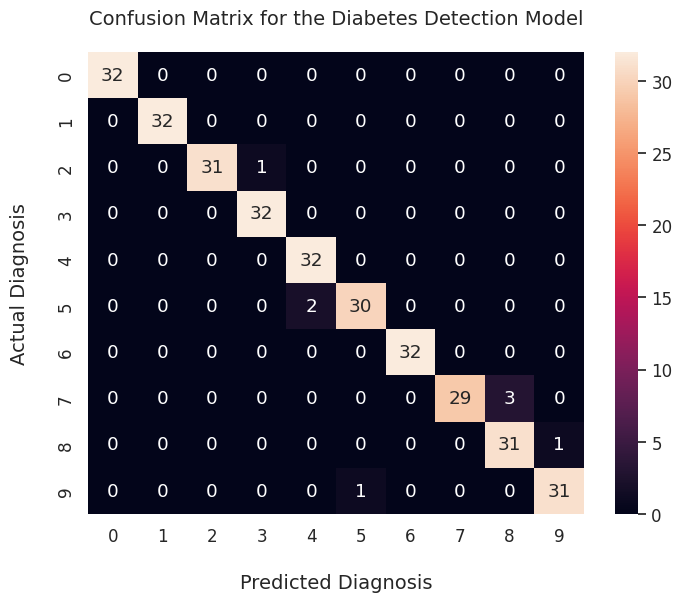

In [18]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [19]:
preds_val = model.predict(valid_generator)

10/10 [==============================] - 6s 610ms/step


In [20]:
evaluate_val = model.evaluate(valid_generator)

10/10 [==============================] - 6s 577ms/step - loss: 6.9482 - accuracy: 0.9770


In [21]:
evaluate_val

[6.948157787322998, 0.9769737124443054]

In [22]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [23]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [24]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9835526315789473

In [25]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 29,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 31,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0, 29,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

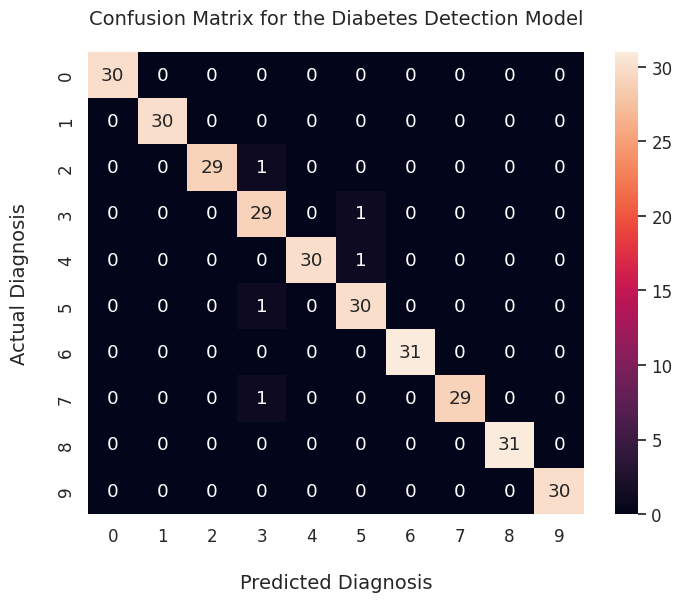

In [26]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()